In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
sys.path.append("/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2")
import expansion as ep
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
qe = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
kB = 1.38064852e-23 # J/K
ramp_time = 5.0e-9 #s (the ramping time for extraction voltage)
f = 1.5e9 # Electrode frequency, in Hertz
fz = 100.0e6 #Hz
omegaz = 2*np.pi*fz

In [45]:
# event_log = []

In [7]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


In [18]:
# # extraction voltage data
# data_DC1 = np.loadtxt("grid_with_ext_voltage_200V_half.fld", skiprows=2)
# # manipulating E field data
# df_DC1 = pd.DataFrame(data_DC1, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
# x_max_DC1, x_min_DC1 = df_DC1.x.max(), df_DC1.x.min()
# y_max_DC1, y_min_DC1 = df_DC1.y.max(), df_DC1.y.min()
# # print(x_max, x_min, y_max, y_min)
# # print(df.y.nunique())
# Nx_DC1, Ny_DC1 = df_DC1.x.nunique() - 1, df_DC1.y.nunique() - 1 # numbers of intervals that divide each dimension
# dx_DC1, dy_DC1 = (x_max_DC1-x_min_DC1)/Nx_DC1, (y_max_DC1-y_min_DC1)/Ny_DC1 # interval size
# print("x_max = ", x_max_DC1*1.0e3, "mm")
# print("y_max = ", y_max_DC1*1.0e3, "mm")
# print("x_min = ", x_min_DC1*1.0e3, "mm")
# print("y_min = ", y_min_DC1*1.0e3, "mm")
# print("spatial resolution x: ", dx_DC1*1.0e6, "um")
# print("spatial resolution y: ", dy_DC1*1.0e6, "um")

In [9]:
# building the axial confinement multipole
Q, scale = ep.spher_harm_basis([0.0, 0.0, 0.0], np.linspace(-250, 250, 101)*1.0e-6, np.linspace(-250, 250, 101)*1.0e-6,\
                        np.linspace(-250, 250, 101)*1.0e-6, 2)
pole = Q.transpose()
DC_V = pole[4] * 0.5*m*(2*np.pi*fz)**2/qe * scale**2
df = pd.DataFrame(DC_V)
# if doesn't include grid, use this:
df.columns = ['V']
# print (df.head(5))
# print (df.tail(5))
V = df.iloc[:,0].values
x = np.arange(-250,251,5) * 1.0e-6
y = np.arange(-250,251,5) * 1.0e-6
z = np.arange(-250,251,5) * 1.0e-6
Z = np.tile(z,len(x)*len(y))
# print (Z)
Y = np.tile(y,(len(x),len(z)))
Y = np.ndarray.flatten(Y.T)
# print (Y)
X = np.tile(x,(len(y)*len(z),1))
X = np.ndarray.flatten(X.T)
# print (X)
df['x'] = X
df['y'] = Y
df['z'] = Z
df = df[["x", "y", "z", "V"]]
df = df.loc[df.z==0]
df = df.reset_index(drop=True)

In [10]:
df["V"].values

array([0.07014365, 0.06875481, 0.06739402, ..., 0.06739402, 0.06875481,
       0.07014365])

In [11]:
# x = np.linspace(-250.0e-6, 250.0e-6, 101)
# y = df.loc[(df.x == 0.0) & (df.y == 0.0)].loc[:, 'V'].values
# plt.plot(x*1.0e6, -y, color="black", marker=".", label="actual voltage")

In [12]:
def compute_E(df):
    """Taken a dataframe with columns x, y, z=0, V, compute the electric field at given location.
    Return a dataframe with columns x, y, z, Ex, Ey, Ez; since we are only interested in 2D here,
    the returned dataframe will have Ez = 0"""
    x_max, x_min = df.x.max(), df.x.min()
    y_max, y_min = df_RF.y.max(), df_RF.y.min()
    Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
    dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
    x_col = df['x'].values
    y_col = df['y'].values
    z_col = np.zeros_like(x_col)
    Ez_col = np.zeros_like(x_col)
    V_array = df["V"].values
    V_XY = np.reshape(V_array,(Nx+1,Ny+1))
    V_XY = V_XY.transpose()
    Ey_XY = - np.gradient(V_XY, dy, dx)[0]
    Ex_XY = - np.gradient(V_XY, dy, dx)[1]
    Ex_col = np.reshape(Ex_XY.transpose(), (Nx+1)*(Ny+1))
    Ey_col = np.reshape(Ey_XY.transpose(), (Nx+1)*(Ny+1))
    data = {'x': x_col, 'y': y_col, 'z': z_col, 'Ex': Ex_col, 'Ey': Ey_col, 'Ez': Ez_col}
    result = pd.DataFrame(data)
    return result
df_DC0 = compute_E(df)

In [13]:
#df_DC0

In [14]:
x_max_DC0, x_min_DC0 = df_DC0.x.max(), df_DC0.x.min()
y_max_DC0, y_min_DC0 = df_DC0.y.max(), df_DC0.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC0, Ny_DC0 = df_DC0.x.nunique() - 1, df_DC0.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC0, dy_DC0 = (x_max_DC0-x_min_DC0)/Nx_DC0, (y_max_DC0-y_min_DC0)/Ny_DC0 # interval size
print("x_max = ", x_max_DC0*1.0e3, "mm")
print("y_max = ", y_max_DC0*1.0e3, "mm")
print("x_min = ", x_min_DC0*1.0e3, "mm")
print("y_min = ", y_min_DC0*1.0e3, "mm")
print("spatial resolution x: ", dx_DC0*1.0e6, "um")
print("spatial resolution y: ", dy_DC0*1.0e6, "um")


x_max =  0.25 mm
y_max =  0.25 mm
x_min =  -0.25 mm
y_min =  -0.25 mm
spatial resolution x:  5.0 um
spatial resolution y:  5.0 um
----------


In [26]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC0 = half_trap(df_DC0, x_max_DC0, x_min_DC0, y_max_DC0, y_min_DC0,\
                      Nx_DC0, Ny_DC0, dx_DC0, dy_DC0, f=0.0)
# trap_DC1 = half_trap(df_DC1, x_max_DC1, x_min_DC1, y_max_DC1, y_min_DC1,\
#                       Nx_DC1, Ny_DC1, dx_DC1, dy_DC1, f=0.0)

In [29]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    g1 = trap_RF.acceleration(x, y, time) + trap_DC0.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC1.hit_electrodes(x, y):
            break
        if y > trap_DC1.y_max:
            extracted = True
            break
        if not trap_DC1.within_boundary(x, y):
            break
        state = trap_DC1.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted

def plot_traj(rho, phi, T, theta, dt, t_max):
    v = np.sqrt(2*kB*T/m) #speed
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    x_traj = []
    y_traj = []
    t_s = []
    trapped = True

    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            print("out of bound")
            trapped = False
            break
        x_traj.append(x)
        y_traj.append(y)
        t_s.append(t)
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

    print("Time step for simulation: ", dt*1.0e9, "ns")
    print("Simulation time duration: ", round(t*1.0e6, 3), "us")

    plt.figure()
    plt.plot(t_s*1.0e6, x_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("x (um)")

    plt.figure()
    plt.plot(t_s*1.0e6, y_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("y (um)")

    plt.figure()
    plt.plot(x_traj*1.0e6, y_traj*1.0e6)
    plt.xlabel("x (um)")
    plt.ylabel("y (um)")
    electrode = df_DC1.loc[(np.abs(df_DC1["Ex"]) < 1.0e-8) & (np.abs(df_DC1["Ey"]) < 1.0e-8)]
    x_electrode = electrode.iloc[:, 0].values
    y_electrode = electrode.iloc[:, 1].values
    plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.")
    plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.")

def trapped(rho, phi, v, theta, dt, t_max):

    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    trapped = True
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_RF.within_boundary(x, y):
            trapped = False
            break
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    return trapped, x, y

Time step for simulation:  0.01 ns
Simulation time duration:  0.05 us


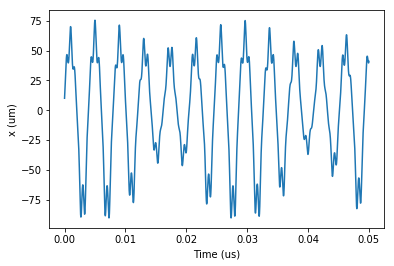

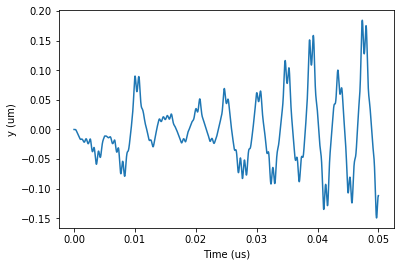

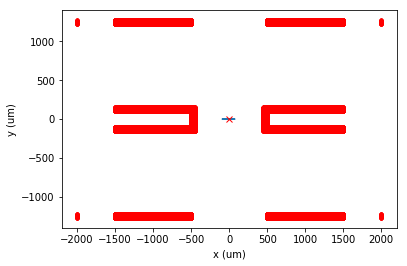

In [31]:
rho = 10.0e-6
phi = 0.0
T = 300.0
v = np.sqrt(2*kB*T/m)
theta = 0.0
dt = 1.0e-11
t_max = 5.0e-8
plot_traj(rho, phi, T, theta, dt, t_max)
plt.plot(trapped(rho, phi, v, theta, dt, t_max)[1], trapped(rho, phi, v, theta, dt, t_max)[2], 'rx')

In [ ]:
dt = 1.0e-11 #s
t_max = 50.0e-9 # maximum time duration of the simulation

#initial condition
rho_s = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 100.0]
rho_s = np.array(rho_s) * 1.0e-6
N_samples = 200
N_phi = None
N_theta = None

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict()
errors = dict()
# for T in [1000.0, 300.0, 100.0, 20.0, 4.0]:
for T in [300.0, 100.0, 20.0, 4.0]:
    v = np.sqrt(2*kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        phi = np.random.rand(N_samples)
        theta = np.random.rand(N_samples)
        for i in range(N_samples):
            success, x_f, y_f = trapped(rho, phi[i], v, theta[i], dt, t_max)
            event_log.append([rho, v, x_f, y_f, success])
            if success:
                result.append(1)
            else:
                result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_samples))
    

Simulating T =  300.0 kelvin


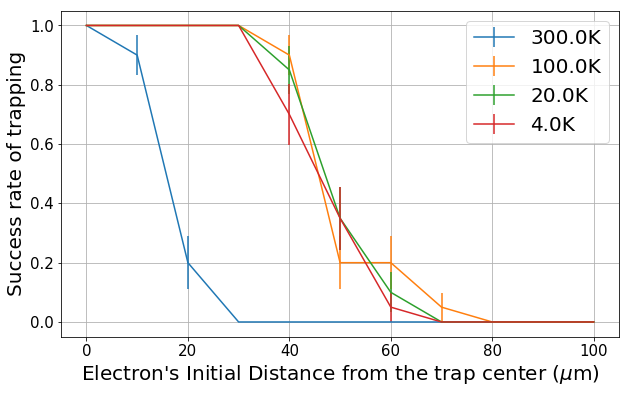

In [51]:
rho_s = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 100.0]
rho_s = np.array(rho_s) * 1.0e-6
plt.figure(figsize=(10,6))
for T in [300.0, 100.0, 20.0, 4.0]:
    plt.errorbar(rho_s*1.0e6, success_rate[T], yerr=errors[T], label = str(T) + "K")
    plt.xlabel("$rho$")
plt.legend(fontsize=20)
plt.xlabel("Electron's Initial Distance from the trap center ($\mu$m)", fontsize=20)
plt.ylabel("Success rate of trapping", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)

## Manipulate the event logs and plot useful things (final positions of electrons, phase diagrams etc.)

In [60]:
event_log_arr = np.array(event_log)
df_event = pd.DataFrame(event_log_arr, columns=['rho_0', 'v_0', 'x_f', 'y_f', 'trapped'])

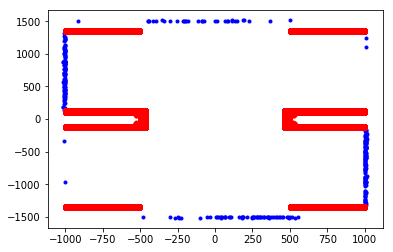

In [68]:
x_fail = df_event[df_event.trapped == 0.0].x_f.values
y_fail = df_event[df_event.trapped == 0.0].y_f.values
plt.plot(x_fail*1.0e6, y_fail*1.0e6, 'b.')
electrode = df_RF.loc[(np.abs(df_RF["Ex"]) < 1.0e-8) & (np.abs(df_RF["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.")
plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.")
plt.plot(x_electrode*1.0e6, -y_electrode*1.0e6, "r.")
plt.plot(-x_electrode*1.0e6, -y_electrode*1.0e6, "r.")

In [71]:
for i in range(len(x_electrode)):
    if not trap_RF.hit_electrodes(x_electrode[i], y_electrode[i]):
        print("oops")


In [72]:
for i in range(len(x_electrode)):
    if trap_RF.within_boundary(x_electrode[i], y_electrode[i]):
        print("oops")

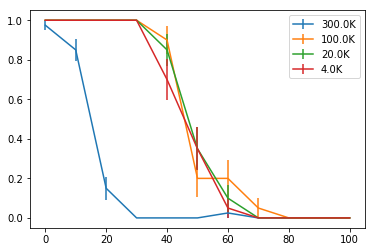

In [83]:
for v in df_event.v_0.unique():
    T = 0.5*m*v**2/kB
    rhos = df_event[df_event.v_0 == v].rho_0.unique()
    success_rate = []
    err = []
    for rho in rhos:
        mean = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].mean()
        std = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].std()
        N = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].shape[0]
        success_rate.append(mean)
        err.append(std/np.sqrt(N))
    plt.errorbar(rho_s*1.0e6, success_rate, yerr=err, label = str(round(T)) + "K")
    
plt.legend()